# Introduction
Hello people, welcome to this kernel. In this kernel we're going to fine tune a pre-trained model using Pytorch. We'll do everything using Pytorch.

In previous kernel I said I'm planning to switch to Pytorch and now today I'll show you a really important thing, transfer learning.

If you don't know what is transfer learning let me explain briefly:

Transfer learning is **training a pre-trained model (a model which trained on a big dataset, such as VGG16 model has trained on ImageNet which has 1000 classes and thousands of images.) using our data.** Maybe you can think *but it has 1000 classes and our data does not have 1000 classes*. We'll drop the fully connected layers, only use convolution layers. 

# Table of Content
1. Preparing Environment
1. Preparing Data
1. Preparing VGG16
1. Training VGG16
1. Conclusion


# Preparing Environment
In this section we're going to import libraries we'll use and read the paths of the images.


In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms


In [2]:
brown_spot = glob("../input/riceleafs/RiceLeafs/train/BrownSpot/*") + glob("../input/riceleafs/RiceLeafs/validation/BrownSpot/*")
healthy = glob("../input/riceleafs/RiceLeafs/train/Healthy/*") + glob("../input/riceleafs/RiceLeafs/validation/Healthy/*")
hispa = glob("../input/riceleafs/RiceLeafs/train/Hispa/*") + glob("../input/riceleafs/RiceLeafs/validation/Hispa/*")
leaf_blast = glob("../input/riceleafs/RiceLeafs/train/LeafBlast/*") + glob("../input/riceleafs/RiceLeafs/validation/LeafBlast/*")

print("Number of brown spot:",len(brown_spot))
print("Number of healthy:",len(healthy))
print("Number of hispa: ",len(hispa))
print("Number of leaf blast:",len(leaf_blast))


Number of brown spot: 523
Number of healthy: 1488
Number of hispa:  565
Number of leaf blast: 779


In [14]:
label_map = {0:"brown_spot",
             1:"healthy",
             2:"hispa",
             3:"leaf_blast"
            }

# Preparing Data

In this section we're going to create a custom dataset class, sampler and loader objects.

In [8]:
class LeafDataset(Dataset):
    
    def __init__(self,paths):
        
        self.x = []
        self.y = []                         # This converts pil image to torch tensor.
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             # We have to normalize data to use in torchvision models.
                                             transforms.Normalize(mean=[0.485, 0.456, 0.406],                                     std=[0.229, 0.224, 0.225])
                                            ])
        
        start = time.time()
        for label,class_paths in enumerate(paths):
            for sample_path in class_paths:
                img = Image.open(sample_path).resize((224,224))
                self.x.append(self.transform(img))
                self.y.append(label)
        end = time.time()
        process_time = round(end-start,2)
        print("Dataset has loaded, that took {} seconds".format(process_time))
        
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return len(self.x)


In [9]:
dataset = LeafDataset((brown_spot,healthy,hispa,leaf_blast))

Dataset has loaded, that took 633.88 seconds


* Now let's get 20 random samples and see how our data seems.

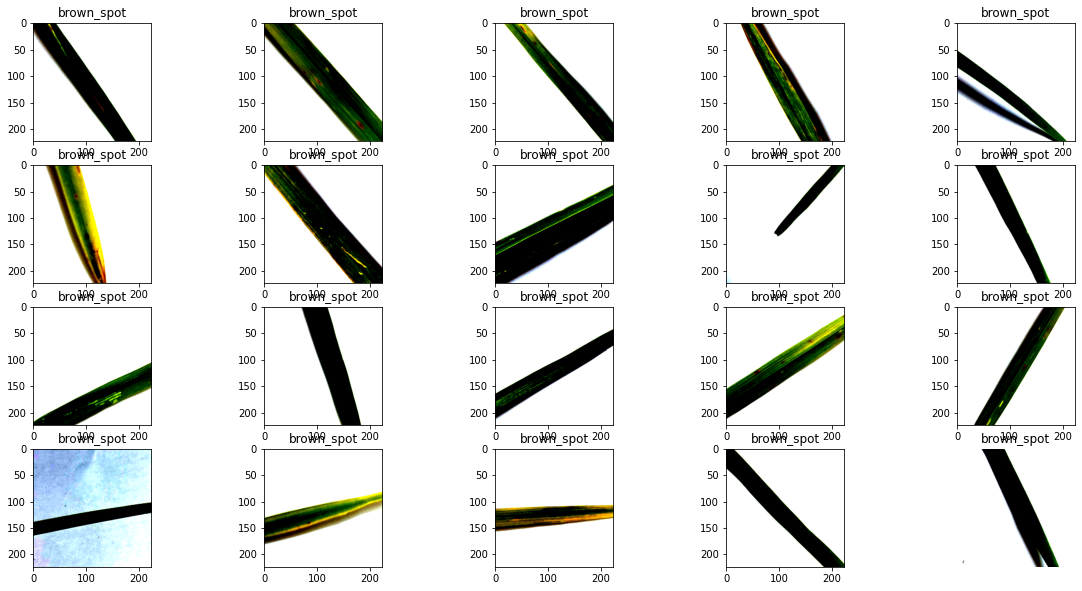

In [16]:
random_sample_indexes = random.choices(range(len(dataset)),k=20)

fig, axis = plt.subplots(4,5, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        
        image,label = dataset[i]
        
        npimg = image.numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        label = label_map[label]
        ax.imshow(npimg)
        ax.set(title = f"{label}")
        plt.axis("off")

In [17]:
np.unique(dataset.y)

array([0, 1, 2, 3])

* Now we'll create subset samplers.


In [18]:
# Splitting indices into train and test sets.
train,test = train_test_split(list(range(len(dataset))))
print(len(train))
print(len(test))

2516
839


In [19]:
train_sampler = SubsetRandomSampler(train)
test_sampler = SubsetRandomSampler(test)

* And finally we can create our loader objects.

In [21]:
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,sampler=test_sampler)


# Preparing VGG16
In this section we're going to load and prepare our VGG16 model.

In [24]:
vgg16 = torchvision.models.vgg16_bn(pretrained=True)

# In transfer learning we don't need to train all layers, 
# actually in this mission we'll just train fully connected layers
# other's will be pre-trained

for param in vgg16.features.parameters():
    param.require_grad = False

# This will return how many features we'll have after flattening.
num_features = vgg16.classifier[6].in_features
num_features

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

4096

* As you see we have 4096 features before the prediction layer, so we'll add a linear layer (in=4096,out=4)

In [25]:
# We did not get the last layer (prediction layer) 
# we'll add our prediction layer.
layers = list(vgg16.classifier.children())[:-1]

layers.append(nn.Linear(num_features,4))

vgg16.classifier = nn.Sequential(*layers)

* Done, now we can train our model.

# Training VGG16
Now we're going to train our model, one of the best things about Pytorch is training is always same and really easy to configure. When we train a transfer learning model, we won't do something different. We'll train it as other models.

In [26]:
# In order to work with gpu, we need to create a device object
device = torch.device("cuda")
print(device)

cuda


In [27]:
# Also we need an optimizer and a loss function
# We'll use RMSprop as optimizer and cross entropy as loss

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(vgg16.parameters(),lr=1e-4)

In [28]:
vgg16 = vgg16.to(device)

In [34]:
EPOCH_NUMBER = 5

for current_epoch in range(1,EPOCH_NUMBER+1):
    epoch_total_train_loss = 0.0
    epoch_total_train_true = 0
    epoch_total_data_len = 0
    
    for images,labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        
        # Cleaning cached gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = vgg16(images)
        
        # Backward propagation
        loss = criterion(outputs,labels)
        loss.backward()
        
        # Optimizing
        optimizer.step()
        
        epoch_total_train_loss += loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_total_train_true += torch.sum(pred == labels).item()
        epoch_total_data_len += labels.size(0)
    
    acc = round(100 * epoch_total_train_true / epoch_total_data_len,2)
    print(f"Epoch {current_epoch} completed: Train loss: {epoch_total_train_loss} Train Accuracy: {acc}")
        

Epoch 1 completed: Train loss: 12.922655880451202 Train Accuracy: 89.35
Epoch 2 completed: Train loss: 9.258275784552097 Train Accuracy: 92.25
Epoch 3 completed: Train loss: 7.008987408131361 Train Accuracy: 94.75
Epoch 4 completed: Train loss: 5.31060554087162 Train Accuracy: 95.99
Epoch 5 completed: Train loss: 4.375952621921897 Train Accuracy: 96.54


* We've trained our model, let's compute validation loss and validation accuracy.

In [37]:
validation_loss = 0.0
validation_correct = 0
validation_total = len(test_sampler)

with torch.no_grad():
    vgg16.eval()
    for data_,target_ in test_loader:
        data_,target_ = data_.to(device),target_.to(device)
        
        outputs = vgg16(data_)
        loss = criterion(outputs,target_).item()
        _,preds = torch.max(outputs,dim=1)
        correct = torch.sum(preds == target_).item()
        validation_loss += loss
        validation_correct += correct

validation_accuracy = round(100 * validation_correct / validation_total,2)
print(f"Validation accuracy: {validation_accuracy}, Validation loss: {validation_loss}")

Validation accuracy: 78.31, Validation loss: 12.057553760707378


* Validation accuracy is pretty worse but we can handle this problem using data augmentation techniques and I'll learn (and also show you xD) it in the next kernel.


# Conclusion
Thanks for your attention, if you have a questions please ask me in the comment section and also mention me. I'll return you as soon as possible.
